In [45]:
# Standard Imports
import pandas as pd
%matplotlib inline 
import seaborn as sns; sns.set()
import numpy as np
import matplotlib.pyplot as plt
import pickle
from matplotlib import pyplot


# Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold


# Utilities
from numpy import absolute
from numpy import mean
from numpy import std
from numpy import arange

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report
from IPython.display import display, Markdown

from imblearn.under_sampling import RandomUnderSampler


In [46]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [47]:
X_train = pd.read_csv('./drive/MyDrive/cars/6-X_train_FINAL.csv')
X_test = pd.read_csv('./drive/MyDrive/cars/6-X_test_FINAL.csv')
X_train=X_train.drop(['MAKE', 'VIN'], axis=1)
X_test=X_test.drop(['MAKE', 'VIN'], axis=1)

In [48]:
# Dropping Nulls
X_train = X_train.dropna(axis=0)
X_test = X_test.dropna(axis=0)

In [49]:
X_train = X_train[X_train['GVW_TYPE'].notna()]
X_test = X_test[X_test['GVW_TYPE'].notna()]

X_train['GVW_TYPE'] = X_train['GVW_TYPE'].astype(int)
X_test['GVW_TYPE'] = X_test['GVW_TYPE'].astype(int)

X_train['VEHICLE_TYPE'] = X_train['VEHICLE_TYPE'].astype(str)
X_train['GVW_TYPE'] = X_train['GVW_TYPE'].astype(str)
X_train['FINAL_CYL'] = X_train['FINAL_CYL'].astype(str)
X_train['OBD_MIL_STATUS'] = X_train['OBD_MIL_STATUS'].astype(bool)

X_test['VEHICLE_TYPE'] = X_test['VEHICLE_TYPE'].astype(str)
X_test['GVW_TYPE'] = X_test['GVW_TYPE'].astype(str)
X_test['FINAL_CYL'] = X_test['FINAL_CYL'].astype(str)
X_test['OBD_MIL_STATUS'] = X_test['OBD_MIL_STATUS'].astype(bool)

In [50]:
X_train.OBD_MIL_STATUS.value_counts()


True     115712
False      3597
Name: OBD_MIL_STATUS, dtype: int64

In [51]:
# getting target feature
y_train = X_train['OVERALL_RESULT']
X_train = X_train.drop('OVERALL_RESULT', axis='columns')
y_train = LabelEncoder().fit_transform(y_train)

y_test = X_test['OVERALL_RESULT']
X_test = X_test.drop('OVERALL_RESULT', axis='columns')
y_test = LabelEncoder().fit_transform(y_test)

In [52]:
print(len(X_train))
print(len(y_train))

119309
119309


In [53]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show();

In [54]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119309 entries, 0 to 126744
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   FINAL_CYL       119309 non-null  object 
 1   CAR_AGE         119309 non-null  float64
 2   GVW_TYPE        119309 non-null  object 
 3   TRANS_TYPE      119309 non-null  object 
 4   DUAL_EXHAUST    119309 non-null  object 
 5   FUEL_TYPE       119309 non-null  object 
 6   VEHICLE_TYPE    119309 non-null  object 
 7   OBD_MIL_STATUS  119309 non-null  bool   
 8   MODEL_YEAR      119309 non-null  int64  
 9   ODOMETER        119309 non-null  float64
 10  AVG_MIL_YEARLY  119309 non-null  float64
dtypes: bool(1), float64(3), int64(1), object(6)
memory usage: 10.1+ MB


In [55]:
categorical_columns = X_train[['ODOMETER','AVG_MIL_YEARLY']].select_dtypes(include='object').columns
len(categorical_columns)


0

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from imblearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import cross_validate



def cross_validate(
    cv,
    balancing_technique,
    model,
    nameTest,
    Comb_X_train,
    Comb_X_test):

    categorical_columns = Comb_X_train.select_dtypes(include='object').columns

    pipeline = make_pipeline(balancing_technique, model)

    if (len(categorical_columns) > 0):
        print(':::::::CATEGORICAL FEATURES FOUND:::::::')
        cat_pipe = make_pipeline(
            OneHotEncoder(handle_unknown="ignore"),
        )

        preprocessor_linear = make_column_transformer(
            (cat_pipe, categorical_columns),
            n_jobs=2,
        )

        pipeline = make_pipeline(
            balancing_technique, preprocessor_linear, model)

    train_acc = []
    test_acc = []
    test_prec = []
    test_recall = []
    test_f1 = []

    for train_ind, val_ind in cv.split(Comb_X_train, y_train):
        X_t, y_t = Comb_X_train.iloc[train_ind], y_train[train_ind]
        pipeline.fit(X_t, y_t)
        y_hat_t = pipeline.predict(X_t)
        train_acc.append(accuracy_score(y_t, y_hat_t))

        X_val, y_val = Comb_X_train.iloc[val_ind], y_train[val_ind]
        y_hat_val = pipeline.predict(X_val)
        test_acc.append(accuracy_score(y_val, y_hat_val))

        y_pred = pipeline.predict(Comb_X_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        F1Sc = f1_score(y_test, y_pred)
        test_prec.append(precision)
        test_recall.append(recall)
        test_f1.append(F1Sc)

    print(evaluation(y_val, y_hat_val))
    print('Training Accuracy: {}'.format(np.mean(train_acc)))
    print('\n')
    print('Validation Accuracy: {}'.format(np.mean(test_acc)))
    print('Test Precision: {}'.format(np.mean(test_prec)))
    print('Test Recall: {}'.format(np.mean(test_recall))) 
    print('Test F1: {}'.format(np.mean(test_f1))) 
    print('\n')

    return [nameTest,
        np.mean(train_acc),
        np.mean(test_acc),
        np.mean(test_prec),
        np.mean(test_recall),
        np.mean(test_f1)]

In [57]:
import itertools as iter

def permutationsCars(lst):
    comb = (iter.combinations(lst, l) for l in range(len(lst) + 1))
    return list(iter.chain.from_iterable(comb))

def listing(lst):
  return list(lst)

#Number of values to use if automatically
var = 10

#ENTER ALL POSSIBLE COLUMNS HERE
listsTries = X_train.columns
permutations = permutationsCars(X_train.columns)
iterationsIndex = permutations[len(listsTries)+1:len(listsTries)*(len(listsTries) - 5)+1]

#AUTOMATIC FROM DF
#permutations = permutationsCars(X_train.columns[:var])
#iterationsIndex = permutations[var+1:]

ColumnNamesPermutation = []
for x in iterationsIndex:
  ColumnNamesPermutation.append(listing(x))

In [58]:
ColumnNamesPermutation

[['FINAL_CYL', 'CAR_AGE'],
 ['FINAL_CYL', 'GVW_TYPE'],
 ['FINAL_CYL', 'TRANS_TYPE'],
 ['FINAL_CYL', 'DUAL_EXHAUST'],
 ['FINAL_CYL', 'FUEL_TYPE'],
 ['FINAL_CYL', 'VEHICLE_TYPE'],
 ['FINAL_CYL', 'OBD_MIL_STATUS'],
 ['FINAL_CYL', 'MODEL_YEAR'],
 ['FINAL_CYL', 'ODOMETER'],
 ['FINAL_CYL', 'AVG_MIL_YEARLY'],
 ['CAR_AGE', 'GVW_TYPE'],
 ['CAR_AGE', 'TRANS_TYPE'],
 ['CAR_AGE', 'DUAL_EXHAUST'],
 ['CAR_AGE', 'FUEL_TYPE'],
 ['CAR_AGE', 'VEHICLE_TYPE'],
 ['CAR_AGE', 'OBD_MIL_STATUS'],
 ['CAR_AGE', 'MODEL_YEAR'],
 ['CAR_AGE', 'ODOMETER'],
 ['CAR_AGE', 'AVG_MIL_YEARLY'],
 ['GVW_TYPE', 'TRANS_TYPE'],
 ['GVW_TYPE', 'DUAL_EXHAUST'],
 ['GVW_TYPE', 'FUEL_TYPE'],
 ['GVW_TYPE', 'VEHICLE_TYPE'],
 ['GVW_TYPE', 'OBD_MIL_STATUS'],
 ['GVW_TYPE', 'MODEL_YEAR'],
 ['GVW_TYPE', 'ODOMETER'],
 ['GVW_TYPE', 'AVG_MIL_YEARLY'],
 ['TRANS_TYPE', 'DUAL_EXHAUST'],
 ['TRANS_TYPE', 'FUEL_TYPE'],
 ['TRANS_TYPE', 'VEHICLE_TYPE'],
 ['TRANS_TYPE', 'OBD_MIL_STATUS'],
 ['TRANS_TYPE', 'MODEL_YEAR'],
 ['TRANS_TYPE', 'ODOMETER'],
 ['TR

In [59]:
len(ColumnNamesPermutation)

55

:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.4258165548098434
Accuracy:  0.4402581618540715
Precision:  0.9479083665338646
F1:  0.5876505094164866


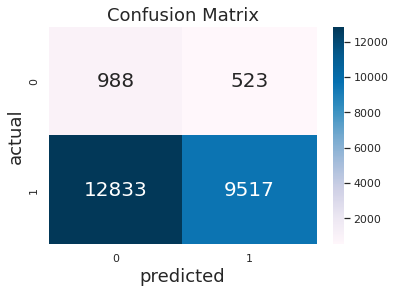

None
Training Accuracy: 0.4375822390532558


Validation Accuracy: 0.4373350118025468
Test Precision: 0.9509193555918098
Test Recall: 0.4190554738767167
Test F1: 0.581730849828724


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.496331096196868
Accuracy:  0.502200243074473
Precision:  0.946986511866143
F1:  0.651303428839831


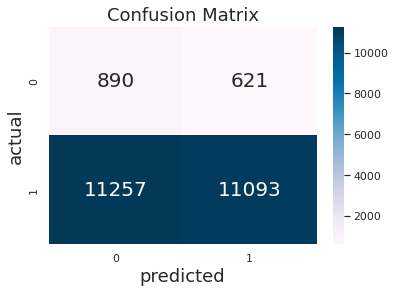

None
Training Accuracy: 0.490922703942415


Validation Accuracy: 0.4904157421862633
Test Precision: 0.9504504268909564
Test Recall: 0.47967153153799263
Test F1: 0.6374745539500262


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.37472035794183445
Accuracy:  0.39688194124303255
Precision:  0.9526788761233079
F1:  0.5378761118782313


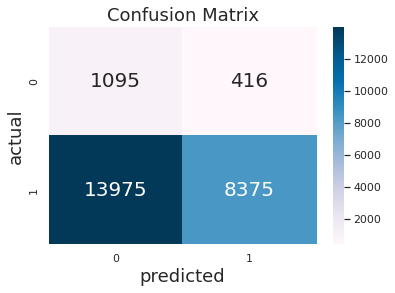

None
Training Accuracy: 0.3969775980915658


Validation Accuracy: 0.39697759518851095
Test Precision: 0.9563156558726311
Test Recall: 0.3711406748664252
Test F1: 0.5347466786775008


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.4258165548098434
Accuracy:  0.4402581618540715
Precision:  0.9479083665338646
F1:  0.5876505094164866


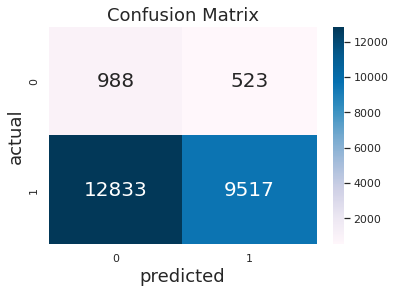

None
Training Accuracy: 0.43791540818077


Validation Accuracy: 0.43760322067020246
Test Precision: 0.9508347785415129
Test Recall: 0.4193997202997813
Test F1: 0.582044283528292


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.42787472035794183
Accuracy:  0.44218599388122876
Precision:  0.9481459448740829
F1:  0.5896534714514737


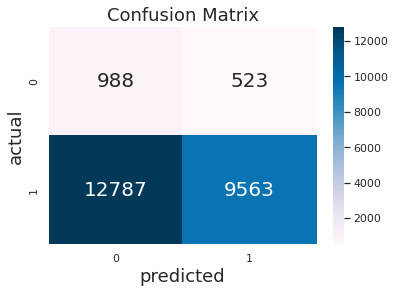

None
Training Accuracy: 0.439681829092196


Validation Accuracy: 0.43948908042908297
Test Precision: 0.9510337243500361
Test Recall: 0.42161580664825904
Test F1: 0.584215111127101


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.5575838926174497
Accuracy:  0.5564729055781401
Precision:  0.9471764079957438
F1:  0.7019460951361702


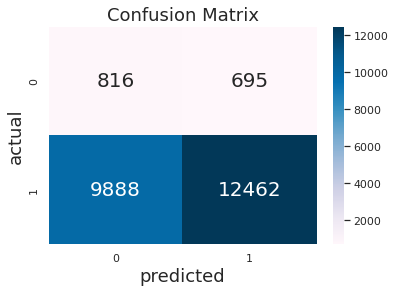

None
Training Accuracy: 0.5513791827585959


Validation Accuracy: 0.5509140597846415
Test Precision: 0.9490181345399936
Test Recall: 0.5494674938143221
Test F1: 0.6959656562993721


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.4258165548098434
Accuracy:  0.4402581618540715
Precision:  0.9479083665338646
F1:  0.5876505094164866


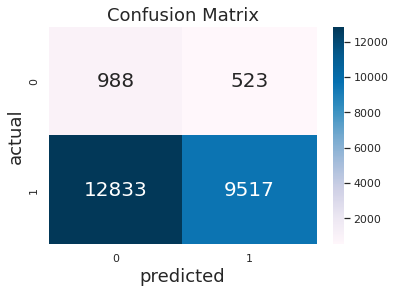

None
Training Accuracy: 0.4375822390532558


Validation Accuracy: 0.4373350118025468
Test Precision: 0.9509193555918098
Test Recall: 0.4190554738767167
Test F1: 0.581730849828724


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.4258165548098434
Accuracy:  0.4402581618540715
Precision:  0.9479083665338646
F1:  0.5876505094164866


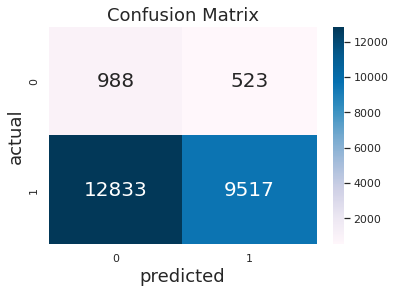

None
Training Accuracy: 0.4375822390532558


Validation Accuracy: 0.4373350118025468
Test Precision: 0.9509193555918098
Test Recall: 0.4190554738767167
Test F1: 0.581730849828724


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.4258165548098434
Accuracy:  0.4402581618540715
Precision:  0.9479083665338646
F1:  0.5876505094164866


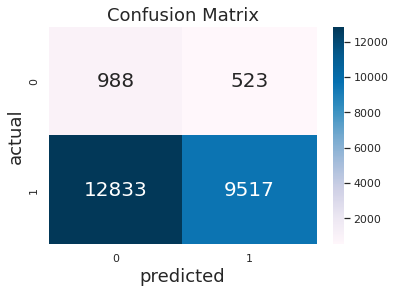

None
Training Accuracy: 0.4375822390532558


Validation Accuracy: 0.4373350118025468
Test Precision: 0.9509193555918098
Test Recall: 0.4190554738767167
Test F1: 0.581730849828724


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.4258165548098434
Accuracy:  0.4402581618540715
Precision:  0.9479083665338646
F1:  0.5876505094164866


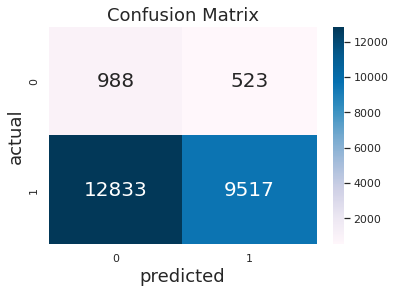

None
Training Accuracy: 0.4375822390532558


Validation Accuracy: 0.4373350118025468
Test Precision: 0.9509193555918098
Test Recall: 0.4190554738767167
Test F1: 0.581730849828724


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.8165548098434005
Accuracy:  0.7775030384309124
Precision:  0.937869366360039
F1:  0.8730177712932621


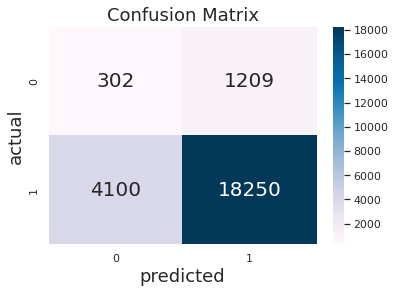

None
Training Accuracy: 0.766480290572521


Validation Accuracy: 0.7664301190431517
Test Precision: 0.9376603049666399
Test Recall: 0.8035572130383333
Test F1: 0.865404311423611


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9233557046979866
Accuracy:  0.8717991701940405
Precision:  0.9387708683983078
F1:  0.9309994811991067


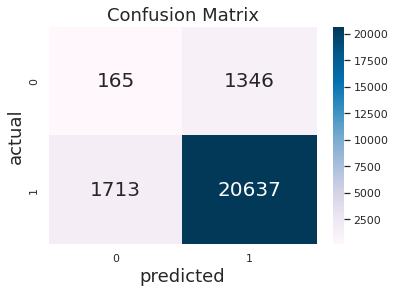

None
Training Accuracy: 0.8725661932633996


Validation Accuracy: 0.8725661872363608
Test Precision: 0.9392015181373623
Test Recall: 0.9228672858321081
Test F1: 0.9309627593192136


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9950335570469798
Accuracy:  0.9324839696576003
Precision:  0.9368128396309869
F1:  0.9650458894747119


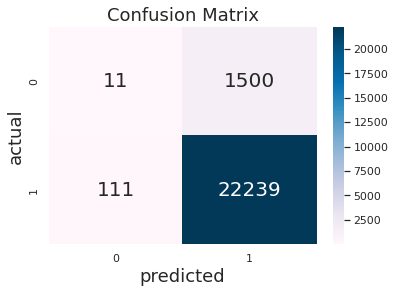

None
Training Accuracy: 0.9323269829586309


Validation Accuracy: 0.9323269841921855
Test Precision: 0.9365669121124096
Test Recall: 0.994298418617994
Test F1: 0.9645695997773641


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.014854586129753915
Accuracy:  0.07711328108629144
Precision:  0.991044776119403
F1:  0.029270443024024685


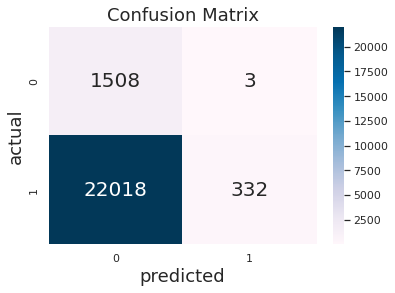

None
Training Accuracy: 0.07635635239006433


Validation Accuracy: 0.07635635833778465
Test Precision: 0.9792626728110599
Test Recall: 0.015240076021085094
Test F1: 0.030013064510433958


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.3157046979865772
Accuracy:  0.34076526549599767
Precision:  0.9418045915643353
F1:  0.4728905569331815


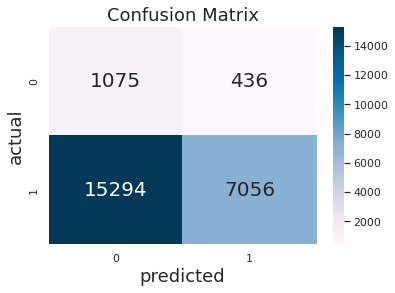

None
Training Accuracy: 0.417617441313462


Validation Accuracy: 0.4164725569127944
Test Precision: 0.9439091799481002
Test Recall: 0.4021945709470363
Test F1: 0.5420385857333303


Recall:  0.916599552572707
Accuracy:  0.893550144587402
Precision:  0.9680559493431623
F1:  0.9416252987681559


None
Training Accuracy: 0.871061647786769


Validation Accuracy: 0.8691969956428178
Test Precision: 0.9716555699787083
Test Recall: 0.8912755047154588
Test F1: 0.929536644305934


Recall:  0.5924384787472036
Accuracy:  0.5998072167972843
Precision:  0.9678386082888678
F1:  0.7349782132052953


None
Training Accuracy: 0.6443898733166517


Validation Accuracy: 0.6445528439126377
Test Precision: 0.9678932981213757
Test Recall: 0.6444866783806075
Test F1: 0.773421180836724


Recall:  0.5633557046979866
Accuracy:  0.564519508821927
Precision:  0.9522044921727293
F1:  0.7078964383099541


None
Training Accuracy: 0.6217510910906944


Validation Accuracy: 0.5682722698810563
Test Precision: 0.9524549165502132
Test Recall: 0.5714418904866067
Test F1: 0.7143059097518403


Recall:  0.5728859060402685
Accuracy:  0.5749549474037132
Precision:  0.9555223880597015
F1:  0.7163076923076922


None
Training Accuracy: 0.625246214285264


Validation Accuracy: 0.577701575349488
Test Precision: 0.9554211320490733
Test Recall: 0.5791874350055581
Test F1: 0.7211816843060515


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.7421476510067114
Accuracy:  0.7143455848455639
Precision:  0.9403061224489796
F1:  0.8295573893473368


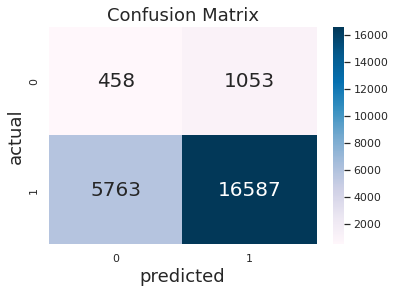

None
Training Accuracy: 0.7046576281713841


Validation Accuracy: 0.7045823011112634
Test Precision: 0.9409125022739921
Test Recall: 0.7290852368487108
Test F1: 0.8215207708593806


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.8122595078299776
Accuracy:  0.7739407401198609
Precision:  0.9380942538238942
F1:  0.8706536856745479


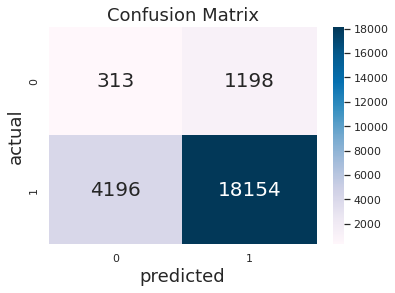

None
Training Accuracy: 0.7626582819150438


Validation Accuracy: 0.7626248758757869
Test Precision: 0.9378577831335854
Test Recall: 0.7988094811202352
Test F1: 0.8627250122213258


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.03646532438478747
Accuracy:  0.095679141695654
Precision:  0.9498834498834499
F1:  0.07023440193036884


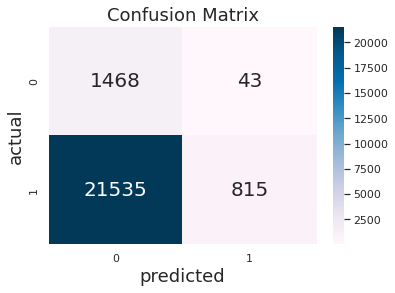

None
Training Accuracy: 0.4941211433422322


Validation Accuracy: 0.4939828654692959
Test Precision: 0.9501339543296737
Test Recall: 0.49251622619858715
Test F1: 0.5396876671575146


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.36899328859060404
Accuracy:  0.38711705293156196
Precision:  0.9405793795620438
F1:  0.5300469181824026


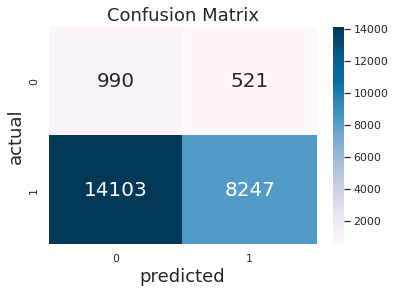

None
Training Accuracy: 0.3907144586634357


Validation Accuracy: 0.39001246431190123
Test Precision: 0.9461780828215268
Test Recall: 0.3714203750851652
Test F1: 0.5114828837967538


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.8165548098434005
Accuracy:  0.7775030384309124
Precision:  0.937869366360039
F1:  0.8730177712932621


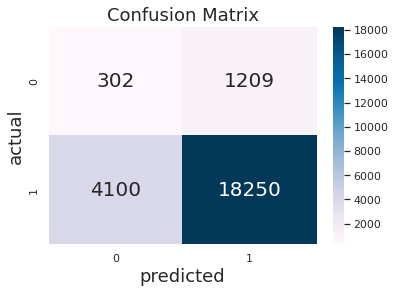

None
Training Accuracy: 0.766480290572521


Validation Accuracy: 0.7664301190431517
Test Precision: 0.9376603049666399
Test Recall: 0.8035572130383333
Test F1: 0.865404311423611


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.8165548098434005
Accuracy:  0.7775030384309124
Precision:  0.937869366360039
F1:  0.8730177712932621


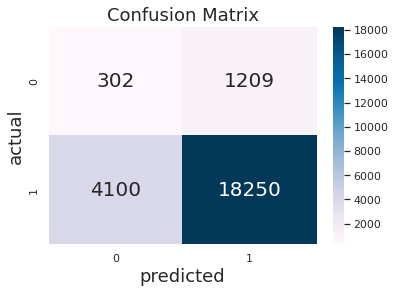

None
Training Accuracy: 0.766480290572521


Validation Accuracy: 0.7664301190431517
Test Precision: 0.9376603049666399
Test Recall: 0.8035572130383333
Test F1: 0.865404311423611


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.8165548098434005
Accuracy:  0.7775030384309124
Precision:  0.937869366360039
F1:  0.8730177712932621


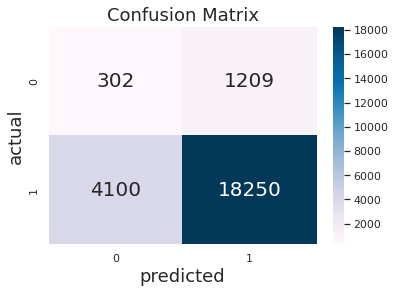

None
Training Accuracy: 0.766480290572521


Validation Accuracy: 0.7664301190431517
Test Precision: 0.9376603049666399
Test Recall: 0.8035572130383333
Test F1: 0.865404311423611


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.8165548098434005
Accuracy:  0.7775030384309124
Precision:  0.937869366360039
F1:  0.8730177712932621


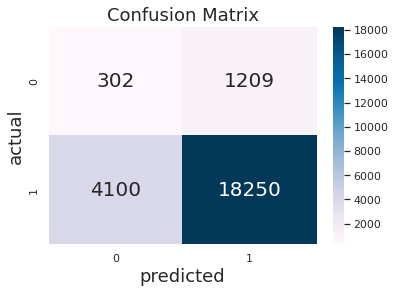

None
Training Accuracy: 0.766480290572521


Validation Accuracy: 0.7664301190431517
Test Precision: 0.9376603049666399
Test Recall: 0.8035572130383333
Test F1: 0.865404311423611


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9195973154362416
Accuracy:  0.8686140564100415
Precision:  0.9388789913663149
F1:  0.9291381297891096


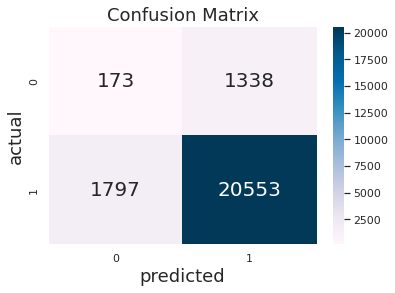

None
Training Accuracy: 0.8690207777668147


Validation Accuracy: 0.8690207745709195
Test Precision: 0.9393594776037272
Test Recall: 0.9182056155197762
Test F1: 0.9286620969789288


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9233557046979866
Accuracy:  0.8717991701940405
Precision:  0.9387708683983078
F1:  0.9309994811991067


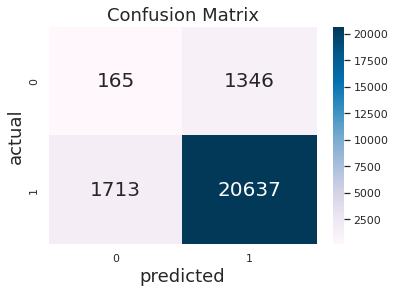

None
Training Accuracy: 0.8725661932633996


Validation Accuracy: 0.8725661872363608
Test Precision: 0.9392015181373623
Test Recall: 0.9228672858321081
Test F1: 0.9309627593192136


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.7194630872483222
Accuracy:  0.6952768115334647
Precision:  0.9413968737193372
F1:  0.8156019375618169


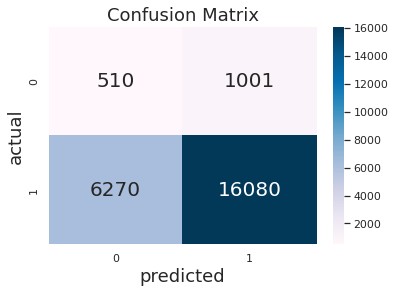

None
Training Accuracy: 0.6927096816452197


Validation Accuracy: 0.692303204063461
Test Precision: 0.9420520266164047
Test Recall: 0.7154946749381432
Test F1: 0.8132790961116261


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9233557046979866
Accuracy:  0.8717991701940405
Precision:  0.9387708683983078
F1:  0.9309994811991067


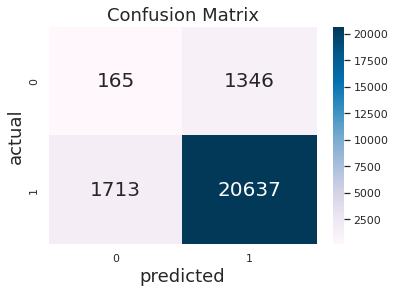

None
Training Accuracy: 0.8725661932633996


Validation Accuracy: 0.8725661872363608
Test Precision: 0.9392015181373623
Test Recall: 0.9228672858321081
Test F1: 0.9309627593192136


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9233557046979866
Accuracy:  0.8717991701940405
Precision:  0.9387708683983078
F1:  0.9309994811991067


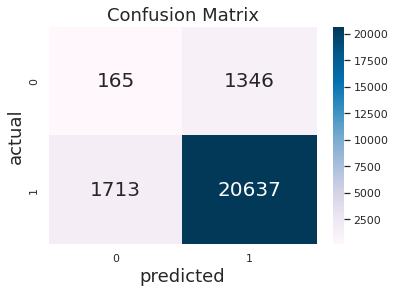

None
Training Accuracy: 0.8725661932633996


Validation Accuracy: 0.8725661872363608
Test Precision: 0.9392015181373623
Test Recall: 0.9228672858321081
Test F1: 0.9309627593192136


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9233557046979866
Accuracy:  0.8717991701940405
Precision:  0.9387708683983078
F1:  0.9309994811991067


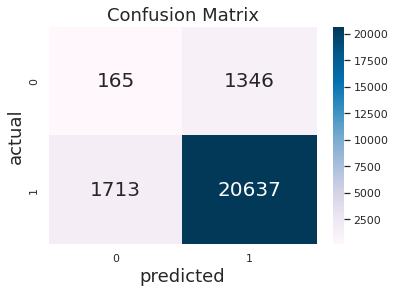

None
Training Accuracy: 0.8725661932633996


Validation Accuracy: 0.8725661872363608
Test Precision: 0.9392015181373623
Test Recall: 0.9228672858321081
Test F1: 0.9309627593192136


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9233557046979866
Accuracy:  0.8717991701940405
Precision:  0.9387708683983078
F1:  0.9309994811991067


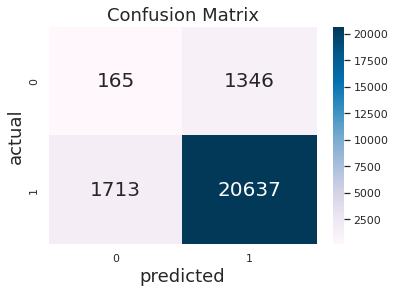

None
Training Accuracy: 0.8725661932633996


Validation Accuracy: 0.8725661872363608
Test Precision: 0.9392015181373623
Test Recall: 0.9228672858321081
Test F1: 0.9309627593192136


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.014854586129753915
Accuracy:  0.07711328108629144
Precision:  0.991044776119403
F1:  0.029270443024024685


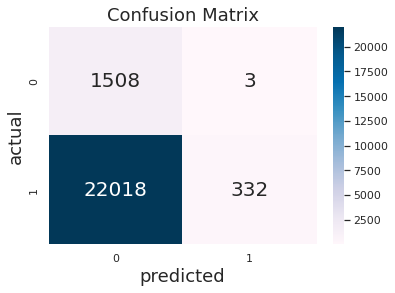

None
Training Accuracy: 0.07635635239006433


Validation Accuracy: 0.07635635833778465
Test Precision: 0.9792626728110599
Test Recall: 0.015240076021085094
Test F1: 0.030013064510433958


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.31530201342281877
Accuracy:  0.3404299903608399
Precision:  0.9418604651162791
F1:  0.4724456958970233


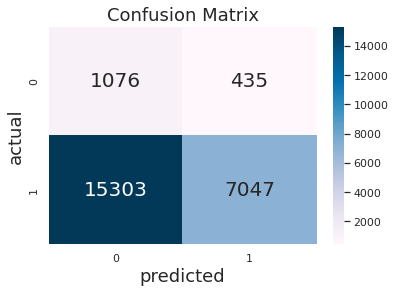

None
Training Accuracy: 0.6573986816687774


Validation Accuracy: 0.6568296071577434
Test Precision: 0.9406553906418369
Test Recall: 0.677498475992398
Test F1: 0.7705689166907044


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9950335570469798
Accuracy:  0.9324839696576003
Precision:  0.9368128396309869
F1:  0.9650458894747119


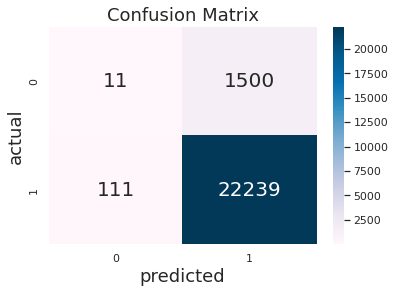

None
Training Accuracy: 0.9323269829586309


Validation Accuracy: 0.9323269841921855
Test Precision: 0.9365669121124096
Test Recall: 0.994298418617994
Test F1: 0.9645695997773641


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9950335570469798
Accuracy:  0.9324839696576003
Precision:  0.9368128396309869
F1:  0.9650458894747119


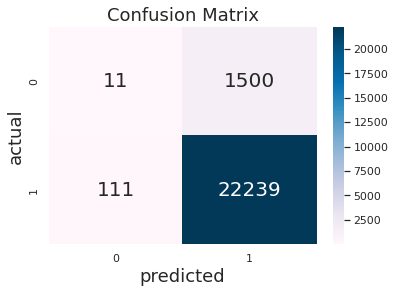

None
Training Accuracy: 0.9323269829586309


Validation Accuracy: 0.9323269841921855
Test Precision: 0.9365669121124096
Test Recall: 0.994298418617994
Test F1: 0.9645695997773641


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9950335570469798
Accuracy:  0.9324839696576003
Precision:  0.9368128396309869
F1:  0.9650458894747119


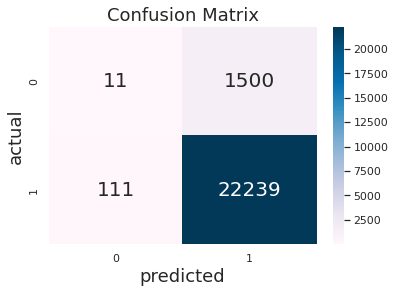

None
Training Accuracy: 0.9323269829586309


Validation Accuracy: 0.9323269841921855
Test Precision: 0.9365669121124096
Test Recall: 0.994298418617994
Test F1: 0.9645695997773641


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.9950335570469798
Accuracy:  0.9324839696576003
Precision:  0.9368128396309869
F1:  0.9650458894747119


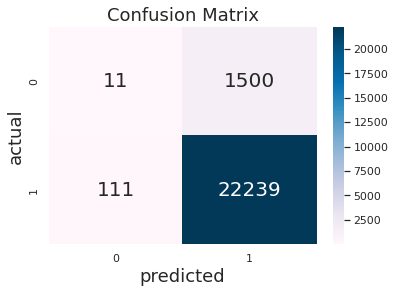

None
Training Accuracy: 0.9323269829586309


Validation Accuracy: 0.9323269841921855
Test Precision: 0.9365669121124096
Test Recall: 0.994298418617994
Test F1: 0.9645695997773641


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.3276510067114094
Accuracy:  0.35182934495620466
Precision:  0.9434424117495491
F1:  0.48638416578108395


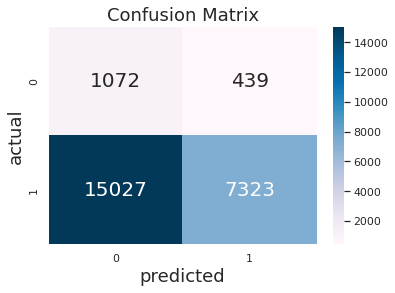

None
Training Accuracy: 0.42620647916941035


Validation Accuracy: 0.4249966627218587
Test Precision: 0.9448380172776021
Test Recall: 0.412486104636569
Test F1: 0.5536752375667262


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.014854586129753915
Accuracy:  0.07711328108629144
Precision:  0.991044776119403
F1:  0.029270443024024685


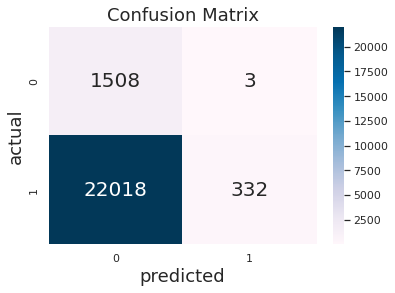

None
Training Accuracy: 0.07635635239006433


Validation Accuracy: 0.07635635833778465
Test Precision: 0.9792626728110599
Test Recall: 0.015240076021085094
Test F1: 0.030013064510433958


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.014854586129753915
Accuracy:  0.07711328108629144
Precision:  0.991044776119403
F1:  0.029270443024024685


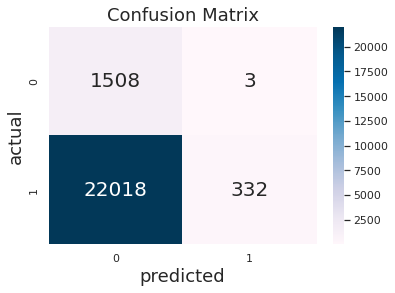

None
Training Accuracy: 0.07635635239006433


Validation Accuracy: 0.07635635833778465
Test Precision: 0.9792626728110599
Test Recall: 0.015240076021085094
Test F1: 0.030013064510433958


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.014854586129753915
Accuracy:  0.07711328108629144
Precision:  0.991044776119403
F1:  0.029270443024024685


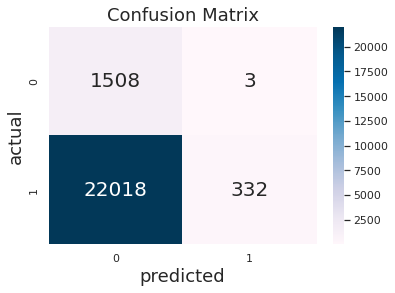

None
Training Accuracy: 0.07635635239006433


Validation Accuracy: 0.07635635833778465
Test Precision: 0.9792626728110599
Test Recall: 0.015240076021085094
Test F1: 0.030013064510433958


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.014854586129753915
Accuracy:  0.07711328108629144
Precision:  0.991044776119403
F1:  0.029270443024024685


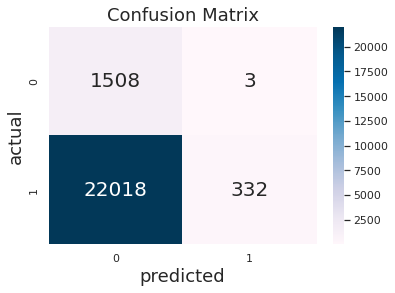

None
Training Accuracy: 0.07635635239006433


Validation Accuracy: 0.07635635833778465
Test Precision: 0.9792626728110599
Test Recall: 0.015240076021085094
Test F1: 0.030013064510433958


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.3157046979865772
Accuracy:  0.34076526549599767
Precision:  0.9418045915643353
F1:  0.4728905569331815


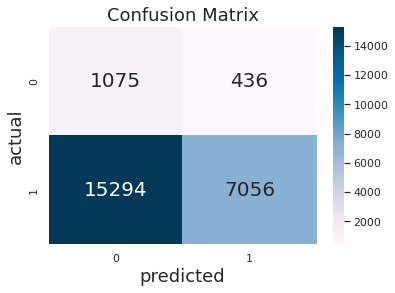

None
Training Accuracy: 0.417617441313462


Validation Accuracy: 0.4164725569127944
Test Precision: 0.9439091799481002
Test Recall: 0.4021945709470363
Test F1: 0.5420385857333303


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.3157046979865772
Accuracy:  0.34076526549599767
Precision:  0.9418045915643353
F1:  0.4728905569331815


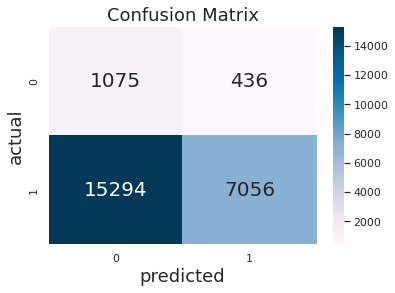

None
Training Accuracy: 0.417617441313462


Validation Accuracy: 0.4164725569127944
Test Precision: 0.9439091799481002
Test Recall: 0.4021945709470363
Test F1: 0.5420385857333303


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.3157046979865772
Accuracy:  0.34076526549599767
Precision:  0.9418045915643353
F1:  0.4728905569331815


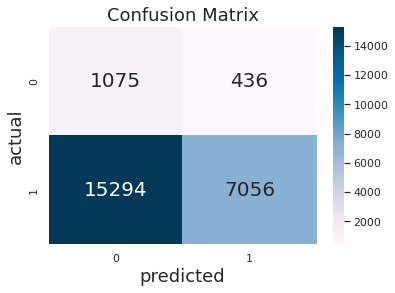

None
Training Accuracy: 0.417617441313462


Validation Accuracy: 0.4164725569127944
Test Precision: 0.9439091799481002
Test Recall: 0.4021945709470363
Test F1: 0.5420385857333303


:::::::CATEGORICAL FEATURES FOUND:::::::
Recall:  0.3157046979865772
Accuracy:  0.34076526549599767
Precision:  0.9418045915643353
F1:  0.4728905569331815


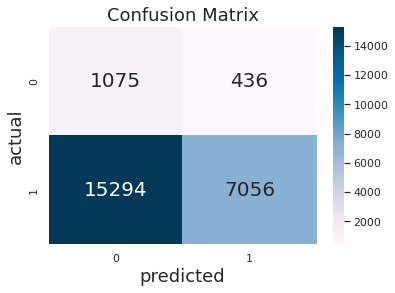

None
Training Accuracy: 0.417617441313462


Validation Accuracy: 0.4164725569127944
Test Precision: 0.9439091799481002
Test Recall: 0.4021945709470363
Test F1: 0.5420385857333303


Recall:  0.916599552572707
Accuracy:  0.893550144587402
Precision:  0.9680559493431623
F1:  0.9416252987681559


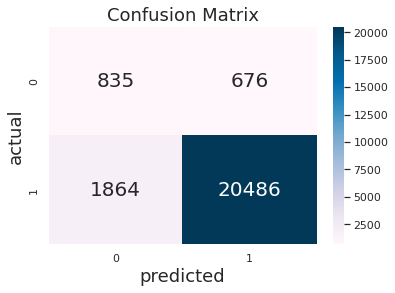

None
Training Accuracy: 0.871061647786769


Validation Accuracy: 0.8691969956428178
Test Precision: 0.9716555699787083
Test Recall: 0.8912755047154588
Test F1: 0.929536644305934


Recall:  0.6858165548098434
Accuracy:  0.6852604668706257
Precision:  0.9691451694486596
F1:  0.8032280039826023


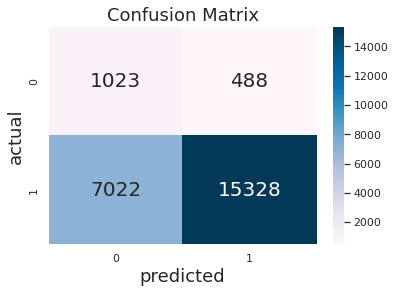

None
Training Accuracy: 0.7184265127241986


Validation Accuracy: 0.6799068415092353
Test Precision: 0.9706040406283444
Test Recall: 0.6776849428048911
Test F1: 0.7981114419079867


Recall:  0.6863982102908277
Accuracy:  0.6843384602489417
Precision:  0.9670322743318205
F1:  0.802899460930549


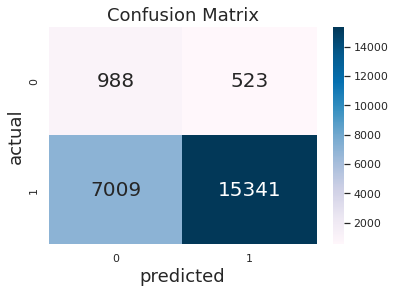

None
Training Accuracy: 0.715465715242025


Validation Accuracy: 0.6814406532433178
Test Precision: 0.9687507031252128
Test Recall: 0.6820669128984832
Test F1: 0.8005080124518342


Recall:  0.5630425055928412
Accuracy:  0.564351871254348
Precision:  0.9523953681979869
F1:  0.7077018249304051


None
Training Accuracy: 0.6215122154165098


Validation Accuracy: 0.5680292041896845
Test Precision: 0.9524807678586249
Test Recall: 0.5710474414601785
Test F1: 0.71400494148178


Recall:  0.5730201342281879
Accuracy:  0.5749968567956079
Precision:  0.9553897799328609
F1:  0.7163753321213815


None
Training Accuracy: 0.6253949871599092


Validation Accuracy: 0.5777937724990092
Test Precision: 0.9553264095845551
Test Recall: 0.5792806684118047
Test F1: 0.7212265973227073


Recall:  0.5901565995525727
Accuracy:  0.5933531704454968
Precision:  0.9604602053447899
F1:  0.7310922040850261


None
Training Accuracy: 0.6461352537384505


Validation Accuracy: 0.5968702820649605
Test Precision: 0.9592718112001503
Test Recall: 0.593315881952164
Test F1: 0.7331558018260791




In [60]:
Models = []
counter = 0
#Random Forest as model chosen
model = RandomForestClassifier(n_estimators=100, random_state=0)

for i,x in enumerate(ColumnNamesPermutation):

  #Balancing technique: UnderSampling
  balancing_technique = RandomUnderSampler(random_state=0)
  nameTest = str(ColumnNamesPermutation[i])

  #Evaluating the model

  Models.append(cross_validate(
    KFold(),
    balancing_technique,
    model,
    nameTest, 
    X_train[ColumnNamesPermutation[i]],
    X_test[ColumnNamesPermutation[i]]))
  counter += 1

In [61]:
ModelsDf =pd.DataFrame(Models)
ModelsDf.columns = ["Variables_Used","TrainAccuracy","ValAccuracy","Precision","Recall","F1Score"]


In [62]:
ModelsDf.iloc[ModelsDf['TrainAccuracy'].idxmax()]

Variables_Used    ['CAR_AGE', 'DUAL_EXHAUST']
TrainAccuracy                        0.932327
ValAccuracy                          0.932327
Precision                            0.936567
Recall                               0.994298
F1Score                               0.96457
Name: 12, dtype: object

In [63]:
ModelsDf.iloc[ModelsDf['ValAccuracy'].idxmax()]

Variables_Used    ['CAR_AGE', 'DUAL_EXHAUST']
TrainAccuracy                        0.932327
ValAccuracy                          0.932327
Precision                            0.936567
Recall                               0.994298
F1Score                               0.96457
Name: 12, dtype: object

In [64]:
ModelsDf.iloc[ModelsDf['Precision'].idxmax()]

Variables_Used    ['CAR_AGE', 'FUEL_TYPE']
TrainAccuracy                    0.0763564
ValAccuracy                      0.0763564
Precision                         0.979263
Recall                           0.0152401
F1Score                          0.0300131
Name: 13, dtype: object

In [65]:
ModelsDf.iloc[ModelsDf['Recall'].idxmax()]

Variables_Used    ['CAR_AGE', 'DUAL_EXHAUST']
TrainAccuracy                        0.932327
ValAccuracy                          0.932327
Precision                            0.936567
Recall                               0.994298
F1Score                               0.96457
Name: 12, dtype: object

In [66]:
ModelsDf.iloc[ModelsDf['F1Score'].idxmax()]

Variables_Used    ['CAR_AGE', 'DUAL_EXHAUST']
TrainAccuracy                        0.932327
ValAccuracy                          0.932327
Precision                            0.936567
Recall                               0.994298
F1Score                               0.96457
Name: 12, dtype: object

In [67]:
ModelsDf.to_csv("./drive/MyDrive/cars/RandomForestResultsOnlyPairs.csv")
